Please fill in your name and that of your teammate.

You: Amine CHARFEDDINE

Teammate: Delil DAG

# Introduction

Welcome to the fourth lab. This week the math load is lower on purpose to give you a chance to catch up on the first 3 labs before we start to _use_ all the foundations you learned so far. You may want to go back and fix your submissions with the help of the solutions, you will need the material for the exam.

This week we introduce the major data analysis library in Python: [`pandas`](https://pandas.pydata.org/docs/). You can think of it as providing **feature-rich data containers**: load your data in a `pandas` object and you will have fast access, manipulation, statistics, even math with `numpy` and plotting with `matplotlib`, all well integrated.  
Unfortunately it also has a fame of being frustrating, unintuitive and stubborn for the newcomers, so I suggest you spend some time practicing and download the documentation as [offline pdf](https://pandas.pydata.org/docs/pandas.pdf) for the exam.

The two main classes are `Series`, for one-dimensional data, and `DataFrame` for _tensors_. You may have heard this word before: you can think of a tensor as a generic structure for feature-based data. A zero-dimensional tensor is a scalar; a 1D tensor is a vector; a 2D tensor is a matrix; you can imagine a 3D tensor as a cube, or as a list of matrices. Higher dimensions are of course hypercubes.  
You will start mostly using `DataFrame`s with 2D tables/matrices, but some methods will return (kind-of) higher-dimensional tensors (e.g. be careful with [`groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)! Takes time to grasp).

This library is best learned hands-on, but before starting it is important to understand how the data is stored and accessed.

## The feature's perspective

Let's look again at our dataset of snakes. It has three fields: `head size`, `length` (in cm) and whether it is `poisonous` or not. It looks like this:

```python
snakes = [['small', 38, False],
          ['small', 62, True],
          ['medium', 55, True]]
```

This form puts the emphasis on the data points (the rows), which is an intuitive approach at first for humans to manually write down the data. We can scroll to the middle of a dataset in a CSV or text file and read one line -- in principle, if the columns are few and we remember their order.  
Accessing the data by indices can also be confusing: if you want to know whether the second snake is poisonous you should use `snakes[1][2]`, which is prone to the type of misunderstandings that lead to bugs (e.g. writing instead `[2][1]`).  
From the machine perspective this is not an issue, but this way of storing has the distinct (performance) disadvantage of having **multiple types** in the same data structure: here we have lists with strings, floats and booleans.

An alternative form to represent the data which is also very common (you already encountered it e.g. for data plotting) gives instead priority to the columns or *features*. It contains the same data, but rows and columns are *transposed*:

```python
snakes = [['small', 'small', 'medium'],
          [38, 62, 55],
          [False, True, True]]
```

As you can see each feature is not in its own list, and all types are the same, meaning we could store it in a specialized array casted to the correct data type, and enjoy a big performance boost.  
Moreover, we can now switch to a hash map (a `dict` in Python), allowing us to include the feature name and use them for indexing, making the data and its description self-contained:

```python
import numpy as np
snakes = {'head_size' : np.array(['small', 'small', 'medium'], dtype='str'),
          'length'    : np.array([38, 62, 55], dtype='float'),
          'poisonous' : np.array([False, True, True], dtype='bool')}
```
This has the added advantage that you can now call the vast library of `numpy` methods on your features, such as: `snakes['length'].mean()`. Create a new cell below, copy+paste the code and give it a try!

Data access readability is also improved by using explicit feature names: `snakes['poisonous'][1]` does not leave room for misunderstandings, it is the `poisonous` field of the first data point. Writing `snakes[1]['poisonous']` will now raise an error (remember: errors are your friends when debugging, what is dangerous is a silent bug).  
One last feature we could add is to add an explicit extra feature called `index` with incremental numbers for the data points, which allows us to explicitly sort the data or access by index as we did before:

```python
import numpy as np
snakes = {'index'     : np.array([1, 2, 3], dtype='int'),
          'head_size' : np.array(['small', 'small', 'medium'], dtype='str'),
          'length'    : np.array([38, 62, 55], dtype='float'),
          'poisonous' : np.array([False, True, True], dtype='bool')}
```
Isn't that neat? Congratulations, you just derived a naïve implementation of a Pandas `DataFrame`. Get used to this name because you will be using it all the time over the next weeks.

## Pandas objects

Let's actually convert our data to a `DataFrame` so we can play with it:

```python
import pandas as pd
df = pd.DataFrame(snakes) # the constructor accept most sensible inputs
df.head() # this prints the first few lines of your (potentially large) dataframe
```

A few tips before we start:
- DataFrames are composed of `Series` to hold the features: Series wrap the Numpy array to extend with more methods, so anything you can do with a Numpy array can be done with most Pandas structures, and much more.
- Data always has an `index` (actually of class `Index`, a special Series), and if you took a database course you should know why (hint: primary key). You can provide an index explicitly, or it will automatically generate one on creation from a counter.
- Accessing data with `[]` (e.g. `df['length']`) does not give direct pointer access at the stored data, but returns a [copy-on-write](https://en.wikipedia.org/wiki/Copy-on-write) handler. This means that creation is free, read access is fast, but trying to write or edit the data first generates a _copy_ of the data, and then edits that. The original is unchanged by `[]`. The full truth is actually even more complex, e.g. try creating a new column `df['new_col'] = 5`, this requires no copy)
- To access the data directly by column name and index, you should use `df.loc[]` (by index and column) and `df.iloc[]` (by indices). Yes they are both methods but they take square parenthesis (ah, python...). Data access is even more confusing than this, and you will need some serious practice to reliably get Pandas to do what you want. Do not skip on this! I suggest you follow [this tutorial](https://medium.com/dunder-data/selecting-subsets-of-data-in-pandas-6fcd0170be9c).
- Sometimes you need to access ranges of values. Ranges in Python are also [weird](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html): keep in mind that you can use the explicit `range()` method, or more commonly the `:` format: `start:end:step`. Funny part, all three are optional: `:k` means from the first to the $k^{th}$ element (excluded: the `end` is never included in a Python range, careful); `p:` means from element number `p` until the end; `::2` means (from beginning to end but only) every second element; and most importantly `:` means all elements. This is necessary as `iloc` always requires rows as first argument, so if you want the third column (implicitly: *values of all rows* for the third column) you need to write `df.iloc[:,2]` (remember indices start from 0). Again, complex to grasp, but super easy and obvious once you get it: practice it!
- You can access the data by "conditions", by generating a boolean array that will hard-select the rows or columns you want. Yeah even more confusing :) bear with me. Try writing `df['length']<60`: this will return a *boolean numpy array*, with values `[True, False, True]`. This is the answer to the boolean question you asked. Now to get the lines of the dataframe that answered True, you need to write `df[df['length']<60]`. Read it and try it until it makes sense before moving forward. Also do yourself a favor and check also the second part of the tutorial above ([boolean indexing](https://www.dunderdata.com/blog/selecting-subsets-of-data-in-pandas-part-2)): all the time you invest now in Pandas will pay dividends later in the harder assignments.
- You can plot the dataframe data directly using the function `df.plot()` (takes `type=` as a parameter), which is sometimes useful for a quick peek. In almost every practical case though it is easier (and produces better results) to simply use `seaborn`, because it integrates DataFrames natively! Finally a good news! try `sns.barplot(data=df, y='length', x=df.index, hue='poisonous')`
- Most DataFrame methods also return the result of a computation as a "copy" or "view" on the Pandas object. If you want your method calls to have persistent consequences, which means you want to modify the original data, you should either (i) capture the output in a variable and use that, or (ii) use the optional argument `inplace=True` which is available for most methods and forces modifying the original data.

### How to pass the lab?

Below you find the exercise questions. Each question awarding points is numbered and states the number of points like this: **[0pt]**. To answer a question, fill the cell below with your answer (markdown for text, code for implementation). Incorrect or incomplete answers are in principle worth 0 points: to assign partial reward is only up to teacher discretion. Over-complete answers do not award extra points (though they are appreciated and will be kept under consideration). Save your work frequently! (`ctrl+s`)

**You need at least 18 points (out of 27 available) to pass** (66%).

# 1. Fundamentals

By now you should be familiar with this. We start easy:

#### 1.1 **[2pt]** Write a small DataFrame with at least 3 of the common problems you can find when dealing with unknown data.

If you need inspiration you can reuse and expand your cats and dogs dataset from lab. Loading into a dataframe should be straightforward: here is the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), pass the table as `data=` and the labels as `columns=` to the constructor.

In [1]:
import pandas as pd
d = {'Firm Name': ["Burger King", "Pizza Hut", "Dominos Pizza", " "], 'Number of employees': [None, 350, 99999, -15], 'Global firm': [True, "Yes !", True, False]}
df = pd.DataFrame(data=d)
df

,Firm Name,Number of employees,Global firm
0,Burger King,NaN,True
1,Pizza Hut,350.0,Yes !
2,Dominos Pizza,99999.0,True
3,,-15.0,False


#### 1.2 **[1pt]** Explain with your own word why data defects mitigation is important and why it cannot ever be perfect.

Here "own word" means that copying and pasting from the slides will actually fail the question. Feel free to discuss around the concepts if the words come hard, just prove that you got the meaning and that you can talk about it. Write as long as you need to show your skills, but no longer (brevity is also a skill that takes practice).

There will always be issues with data because there is a lot of information involved and many agents (whether human or machines) take part in the process of collecting and reporting data. Therefore, there will be imprecisions, mistakes, inaccuracies, oversights... Moreover, to process the data we have to get rid of all those defects because otherwise it is not possible to analyze the data at a large level (what we call "big data") and hence, it will be difficult to find a correlation, patterns and other interesting intel we could have gotten with the data after defects mitigation. That is why data defect mitigation is so important. However, it cannot ever be perfect, because as explained, there is a large quantity of information (sometimes thousands of rows) and there is an infinite number of ways a value can be wrongly inserted: mistake in English, not the right format, missing values, redundancy... It is difficult to think about all the possibilities of how can someone make a wrong input. 

#### 1.3 **[1pt]** Give two reasons why to drop lines with defects rather than fixing them.

1. Fixing them may involve making assumptions or modifying the original data, which can compromise data integrity. <br>
   By dropping lines with defects, the integrity is preserved.
2. Fixing them can also be time-consuming and take a lot of resources, particularly if they are a lot of defects. <br>
   Dropping them is a straightforward and efficient approach.

#### 1.4 **[1pt]** Why does data quality impact learning more than data quantity? Mention one of the algorithms seen so far as an example.

Data quality impacts learning more than data quantity because the accuracy and reliability of the data influence the performance of machine learning algorithms. Even with a large quantity of data, if the data is of poor quality (with errors, inconsistencies, biases...) the resulting model will be inaccurate and unreliable.

One example of an algorithm we have seen where data quality significantly impacts learning is decision trees. Decision trees are sensitive to noisy or erroneous data. With poor-quality data, decision trees may produce inaccurate predictions by making incorrect splits for instance. However, with high-quality data, decision trees can effectively learn meaningful patterns, leading to more accurate models.

#### 1.5 **[1pt]** Convert (by hand!) a categorical feature from your hand-written dataset into a numerical one using binary encoding.

This means that you need to rewrite the hand-written dataset, but a previously categorical feature needs to be written in binary encoding.  
If your dataset did not have a categorical feature yet, go ahead and simply add one.  
IMPORTANT: you may want to go ahead and fix the defects that you introduced earlier, or you may encounter problems.

In [2]:
d = {'Firm Name': ["Burger King", "Pizza Hut", "Dominos Pizza", "Pronto Pizza "], 'Number of employees': [230, 350, 190, 15], 'Global firm': [1, 1, 1, 0]}
df = pd.DataFrame(data=d) # We fixed the defects, and converted the column "Global firm"
df

,Firm Name,Number of employees,Global firm
0,Burger King,230,1
1,Pizza Hut,350,1
2,Dominos Pizza,190,1
3,Pronto Pizza,15,0


#### 1.6 **[1pt]** Consider 5-fold cross-validation: how many models does it train? Now take the first fold: how many of the models that were trained did in fact use this particular fold as part of their training set?

In 5-fold cross-validation, 5 models are trained. <br>
In  4 out of 5 models that were trained, the first fold was part of their training set (in the last one it is used for testing instead).

# 2. Loading data

To simplify the process, here's a CSV string rather than a separate file. You are free to copy this string into a file if you like, the call below simply emulates an Input Output object (such a file) from a String using a `StringIO` object. It is often a useful trick to have on your tool belt.

**IMPORTANT**: do not edit the string! The defects and problems are on purpose! It simulates problematic data that was passed to you unclean, potentially too big to read for a human, and you need to use only Pandas to load and clean the data.

In [3]:
from io import StringIO
csv_str = StringIO('sepal_length$sepal_width$petal_length$petal_width$species$is_flower\n0$5.1$-3.5$1.4$0.2$setosa$True\n1$-3.0$1.4$setosa$True\n2$5.0$-3.6$1.4$0.2$setosa$True\n3$4.6$-3.1$1.5$0.2$setosa$I guess\n4$4.7$-3.2$1.3$0.2$zetosa$True\n5$5.4$-3.9$1.7$0.4$setosa$True\n6$4.6$-3.4$1.4$0.3$setosa$True\n7$5.0$-3.4$1.5$0.2$setosa$Fals\n8$4.4$-2.9$1.4$0.2$setosa$True\n9$4.9$-3.1$1.5$0.1$setosa$True\n10$5.4$-3.7$1.5$0.2$setosa$I guess\n11$4.8$-3.4$1.6$0.2$setosa$True\n12$4.8$-3.0$1.4$0.1$setosa$True\n13$4.3$-3.0$1.1$0.1$setosa$True\n14$5.8$-4.0$1.2$0.2$setosa$True\n15$-4.4$1.5$setosa$True\n16$5.4$-3.9$1.3$0.4$setosa$True\n17$5.1$-3.5$1.4$0.3$setosa$True\n18$5.7$-3.8$1.7$0.3$setosa$True\n19$5.1$-3.8$1.5$0.3$setosa$True\n20$5.4$-3.4$1.7$0.2$setosa$True\n21$5.1$-3.7$1.5$0.4$setosa$True\n22$4.6$-3.6$1.0$0.2$setosa$True\n23$5.1$-3.3$1.7$0.5$setosa$Fals\n24$4.8$-3.4$1.9$0.2$setosa$True\n25$5.0$-3.0$1.6$0.2$setosa$True\n26$5.0$-3.4$1.6$0.4$setosa$True\n27$5.2$-3.5$1.5$0.2$setosa$True\n28$5.2$-3.4$1.4$0.2$setosa$True\n29$4.7$-3.2$1.6$0.2$setosa$True\n30$4.8$-3.1$1.6$0.2$setosa$True\n31$5.4$-3.4$1.5$0.4$setosa$True\n32$5.2$-4.1$1.5$0.1$setosa$Fals\n33$5.5$-4.2$1.4$0.2$setosa$True\n34$4.9$-3.1$1.5$0.2$setosa$True\n35$5.0$-3.2$1.2$0.2$setosa$True\n36$5.5$-3.5$1.3$0.2$setosa$True\n37$4.9$-3.6$1.4$0.1$setosa$True\n38$4.4$-3.0$1.3$0.2$setosa$True\n39$5.1$-3.4$1.5$0.2$setosa$True\n40$5.0$-3.5$1.3$0.3$setosa$True\n41$4.5$-2.3$1.3$0.3$setosa$True\n42$4.4$-3.2$1.3$0.2$setosa$True\n43$5.0$-3.5$1.6$0.6$setosa$True\n44$5.1$-3.8$1.9$0.4$setosa$True\n45$4.8$-3.0$1.4$0.3$setosa$True\n46$5.1$-3.8$1.6$0.2$setosa$True\n47$4.6$-3.2$1.4$0.2$setosa$True\n48$5.3$-3.7$1.5$0.2$setosa$True\n49$5.0$-3.3$1.4$0.2$setosa$True\n50$7.0$-3.2$4.7$1.4$versicolor$True\n51$6.4$-3.2$4.5$1.5$versicolor$True\n52$6.9$-3.1$4.9$1.5$versicolor$I guess\n53$5.5$-2.3$4.0$1.3$versicolor$True\n54$6.5$-2.8$4.6$1.5$versicolor$True\n55$5.7$-2.8$4.5$1.3$versicolor$True\n56$6.3$-3.3$4.7$1.6$versicolor$True\n57$4.9$-2.4$3.3$1.0$versicolor$True\n58$6.6$-2.9$4.6$1.3$versicolor$True\n59$5.2$-2.7$3.9$1.4$versicolor$True\n60$5.0$-2.0$3.5$1.0$versicolor$True\n61$5.9$-3.0$4.2$1.5$versicolor$True\n62$6.0$-2.2$4.0$1.0$versicolor$True\n63$6.1$-2.9$4.7$1.4$versicolor$True\n64$5.6$-2.9$3.6$1.3$versicolor$True\n65$6.7$-3.1$4.4$1.4$versicolor$True\n66$5.6$-3.0$4.5$1.5$versicolor$True\n67$5.8$-2.7$4.1$1.0$versicolor$True\n68$6.2$-2.2$4.5$1.5$versicolor$True\n69$5.6$-2.5$3.9$1.1$versicolor$True\n70$5.9$-3.2$4.8$1.8$versicolor$True\n71$6.1$-2.8$4.0$1.3$versicolor$True\n72$6.3$-2.5$4.9$1.5$versicolor$True\n73$6.1$-2.8$4.7$1.2$versicolor$True\n74$6.4$-2.9$4.3$1.3$😉$True\n75$6.6$-3.0$4.4$1.4$versicolor$True\n76$6.8$-2.8$4.8$1.4$versicolor$True\n77$6.7$-3.0$5.0$1.7$versicolor$True\n78$6.0$-2.9$4.5$1.5$versicolor$True\n79$5.7$-2.6$3.5$1.0$$$$versicolor$True\n80$5.5$-2.4$3.8$1.1$versicolor$True\n81$5.5$-2.4$3.7$1.0$versicolor$True\n82$5.8$-2.7$3.9$1.2$versicolor$True\n83$6.0$-2.7$5.1$1.6$versicolor$True\n84$5.4$-3.0$4.5$1.5$versicolor$True\n85$6.0$-3.4$4.5$1.6$versicolor$True\n86$6.7$-3.1$4.7$1.5$versicolor$True\n87$6.3$-2.3$4.4$1.3$versicolor$True\n88$-3.0$4.1$versicolor$True\n89$5.5$-2.5$4.0$1.3$😉$True\n90$5.5$-2.6$4.4$1.2$versicolor$True\n91$6.1$-3.0$4.6$1.4$versicolor$True\n92$5.8$-2.6$4.0$1.2$versicolor$True\n93$5.0$-2.3$3.3$1.0$versicolor$True\n94$5.6$-2.7$4.2$1.3$versicolor$True\n95$5.7$-3.0$4.2$1.2$versicolor$True\n96$5.7$-2.9$4.2$1.3$versicolor$True\n97$6.2$-2.9$4.3$1.3$versicolor$True\n98$5.1$-2.5$3.0$1.1$versicolor$True\n99$5.7$-2.8$4.1$1.3$versicolor$True\n100$6.3$-3.3$6.0$2.5$virginica$True\n101$5.8$-2.7$5.1$1.9$virginica$True\n102$7.1$-3.0$5.9$2.1$virginica$True\n103$6.3$-2.9$5.6$1.8$virginica$True\n104$6.5$-3.0$5.8$2.2$virginica$True\n105$7.6$-3.0$6.6$2.1$virginica$True\n106$4.9$-2.5$4.5$1.7$virginica$True\n107$7.3$-2.9$6.3$1.8$virginica$True\n108$6.7$-2.5$5.8$1.8$virginica$True\n109$7.2$-3.6$6.1$2.5$virginica$True\n110$6.5$-3.2$5.1$2.0$virginica$True\n111$6.4$-2.7$5.3$1.9$virginica$True\n112$6.8$-3.0$5.5$2.1$virginica$True\n113$5.7$-2.5$5.0$2.0$virginica$True\n114$5.8$-2.8$5.1$2.4$virginica$True\n115$6.4$-3.2$5.3$2.3$virginica$True\n116$6.5$-3.0$5.5$1.8$virginica$True\n117$7.7$-3.8$6.7$2.2$virginica$True\n118$7.7$-2.6$6.9$2.3$virginica$True\n119$6.0$-2.2$5.0$1.5$virginica$True\n120$6.9$-3.2$5.7$2.3$virginica$True\n121$5.6$-2.8$4.9$2.0$virginica$True\n122$7.7$-2.8$6.7$2.0$virginica$True\n123$6.3$-2.7$4.9$1.8$virginica$True\n124$6.7$-3.3$5.7$2.1$virginica$True\n125$7.2$-3.2$6.0$1.8$virginica$True\n126$6.2$-2.8$4.8$1.8$virginica$True\n127$6.1$-3.0$4.9$1.8$virginica$True\n128$6.4$-2.8$5.6$2.1$virginica$True\n129$7.2$-3.0$5.8$1.6$virginica$True\n130$7.4$$$$-2.8$6.1$1.9$virginica$True\n131$7.9$-3.8$6.4$2.0$virginica$True\n132$6.4$-2.8$5.6$2.2$virginica$True\n133$6.3$-2.8$5.1$1.5$virginica$True\n134$6.1$-2.6$5.6$1.4$virginica$True\n135$7.7$-3.0$6.1$2.3$virginica$True\n136$6.3$-3.4$5.6$2.4$virginica$True\n137$6.4$-3.1$5.5$1.8$virginica$True\n138$6.0$-3.0$4.8$1.8$virginica$True\n139$6.9$-3.1$5.4$2.1$virginica$True\n140$6.7$-3.1$5.6$2.4$virginica$True\n141$6.9$-3.1$5.1$2.3$virginica$True\n142$-2.7$5.1$virginica$True\n143$6.8$-3.2$5.9$2.3$virginica$True\n144$6.7$-3.3$5.7$2.5$virginica$True\n145$6.7$-3.0$5.2$2.3$virginica$True\n146$6.3$-2.5$5.0$1.9$virginica$True\n147$6.5$-3.0$5.2$2.0$virginica$True\n148$6.2$-3.4$5.4$2.3$virginica$True\n149$5.9$-3.0$5.1$1.8$virginica$True\n')
print('Data loaded')

Data loaded


#### 2.1 **[2pt]** Load the data despite the errors.

- Be patient
- Peruse the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
- If Python raises an error, read carefully the message at the end of the output cell
- You should not need a `try... except`: make Pandas get the format until there are no errors
- You will need to skip the lines with errors that impede loading (it will still generate warnings, but that is fine for now)
- To print the DataFrame, a simple `df` often looks better in Jupyter notebooks than an explicit `print(df)`

In [4]:
df = pd.read_csv(csv_str,sep = '$', on_bad_lines = "skip")  #Without the third argument we get an error ("expected 7 fields, saw 10")
df

,sepal_length,sepal_width,petal_length,petal_width,species,is_flower
0,5.1,-3.5,1.4,0.2,setosa,True
1,-3.0,1.4,setosa,True,NaN,NaN
2,5.0,-3.6,1.4,0.2,setosa,True
3,4.6,-3.1,1.5,0.2,setosa,I guess
4,4.7,-3.2,1.3,0.2,zetosa,True
...,...,...,...,...,...,...
145,6.7,-3.0,5.2,2.3,virginica,True
146,6.3,-2.5,5.0,1.9,virginica,True
147,6.5,-3.0,5.2,2.0,virginica,True
148,6.2,-3.4,5.4,2.3,virginica,True


#### 2.2 **[1pt]** Explore the DataFrame, and try to spot the defects. Mitigate two by hand.

You may want to learn about the method `head()`. Also calling `unique()` on a Series will give you the set of different values available. Remember the goal of the question is to fix only two errors for now.

In [5]:
# Manually correcting errors

df.loc[1, "sepal_length"] = 3 #a sepal length should be positive
df.loc[3, "is_flower"] = True #we only want True/False for this category

df

,sepal_length,sepal_width,petal_length,petal_width,species,is_flower
0,5.1,-3.5,1.4,0.2,setosa,True
1,3.0,1.4,setosa,True,NaN,NaN
2,5.0,-3.6,1.4,0.2,setosa,True
3,4.6,-3.1,1.5,0.2,setosa,True
4,4.7,-3.2,1.3,0.2,zetosa,True
...,...,...,...,...,...,...
145,6.7,-3.0,5.2,2.3,virginica,True
146,6.3,-2.5,5.0,1.9,virginica,True
147,6.5,-3.0,5.2,2.0,virginica,True
148,6.2,-3.4,5.4,2.3,virginica,True


# 3. Cleaning the data

The following questions require you to either write a Python function or some automated Python code: manually selecting (like last question) for example rows with missing values is not accepted here, you need to provide code that will work with any (unknown) dataset and rows.  
NOTE: no two students ever followed the same process in this exercises, but for those who copy from last year's solutions. As per University policy on plagiarism, students have been expelled from their course of study for something as cheap as an ungraded assignment. Unbelievable. Please not again.

#### 3.1 **[1pt]** Remove all rows with missing values.

[This](https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/) can help (and [geeksforgeeks.org](https://www.geeksforgeeks.org) is a great resource to keep in mind). Also consider customizing the Pandas display options, for example: `pd.set_option("display.max_rows", 200)` to see more than just a few lines (see more options in the method's documentation).

In [6]:
pd.set_option("display.max_rows", 200)

df = df.dropna()
df

,sepal_length,sepal_width,petal_length,petal_width,species,is_flower
0,5.1,-3.5,1.4,0.2,setosa,True
2,5.0,-3.6,1.4,0.2,setosa,True
3,4.6,-3.1,1.5,0.2,setosa,True
4,4.7,-3.2,1.3,0.2,zetosa,True
5,5.4,-3.9,1.7,0.4,setosa,True
6,4.6,-3.4,1.4,0.3,setosa,True
7,5.0,-3.4,1.5,0.2,setosa,Fals
8,4.4,-2.9,1.4,0.2,setosa,True
9,4.9,-3.1,1.5,0.1,setosa,True
10,5.4,-3.7,1.5,0.2,setosa,I guess


In [7]:
# For the next question, here are the correct types for the columns:
corr_types = {'sepal_length' : 'float',
              'sepal_width' : 'float',
              'petal_length' : 'float',
              'petal_width' : 'float',
              'species' : 'string',
              'is_flower' : 'bool'
             }

#### 3.2 **[1pt]** Check the column types. Find the reason for the columns having wrong type, and write it. Mitigate the defects and cast the column to the correct type.

In [8]:
column_types = df.dtypes
print("Initial column types: \n")
print(column_types)

# The are some "object" type, which is due to the presence of mixed data types (emojis in the "species" column for instance)

df = df.astype(corr_types)
column_types = df.dtypes
print("\nCorrected column types: \n")
print(column_types)

Initial column types: 

sepal_length    float64
sepal_width     float64
petal_length     object
petal_width      object
species          object
is_flower        object
dtype: object

Corrected column types: 

sepal_length           float64
sepal_width            float64
petal_length           float64
petal_width            float64
species         string[python]
is_flower                 bool
dtype: object


#### 3.3 **[1pt]** Remove all columns with constant values.

I used `loc` and a boolean array with `nunique`.

In [9]:
#print(df.nunique())
df = df.loc[:,df.nunique() != 1]
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,-3.5,1.4,0.2,setosa
2,5.0,-3.6,1.4,0.2,setosa
3,4.6,-3.1,1.5,0.2,setosa
4,4.7,-3.2,1.3,0.2,zetosa
5,5.4,-3.9,1.7,0.4,setosa
6,4.6,-3.4,1.4,0.3,setosa
7,5.0,-3.4,1.5,0.2,setosa
8,4.4,-2.9,1.4,0.2,setosa
9,4.9,-3.1,1.5,0.1,setosa
10,5.4,-3.7,1.5,0.2,setosa


#### 3.4 **[3pt]** There are still errors in the data: fix them all.

This time, I suggest you do not just "answer" this question in order. It is easier to move to the next questions, see what errors you get, come back and write code that fixes them (remember: data analysis is an iterative process). If you can answer all questions then there should be no errors left. Also keep in mind that Python 3 strings handle UTF-8 characters if you have not noticed already 😉

In [10]:
df['sepal_width'] = df['sepal_width'].abs() # sepal width should be positive
df = df.loc[df['species'] != '😉'] # some rows have smiley face in species column
df.loc[df['species'] == 'zetosa', 'species'] = 'setosa' # some name is "zetosa" instead of setosa

df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
2,5.0,3.6,1.4,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,4.7,3.2,1.3,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa
10,5.4,3.7,1.5,0.2,setosa


# 4. Visualizing the data

If you are still stuck with some error and need to give up on question 3.4, you can use the correct dataframe from `df = sns.load_dataset('iris')` for the following parts. But it would be really great if you were able to clean the data at the previous question and use that instead. As I mentioned: never underestimate the data cleaning.

In [11]:
# I hope you will not uncomment the following line; but if you need to, it is fine, do not worry:
# df = sns.load_dataset('iris'); df

#### 4.1 **[1pt]** Start with plotting the pair-plot, using different colors depending on species. Explain the plots on the diagonal.

Hint: a common error in the past has been if the types have been altered by the fixing in 3.4. To avoid that: use `loc` or `iloc` specifying *always* both row and column. To fix it with bruteforce: re-cast the Series to the correct `dtype` as you did in 3.1.

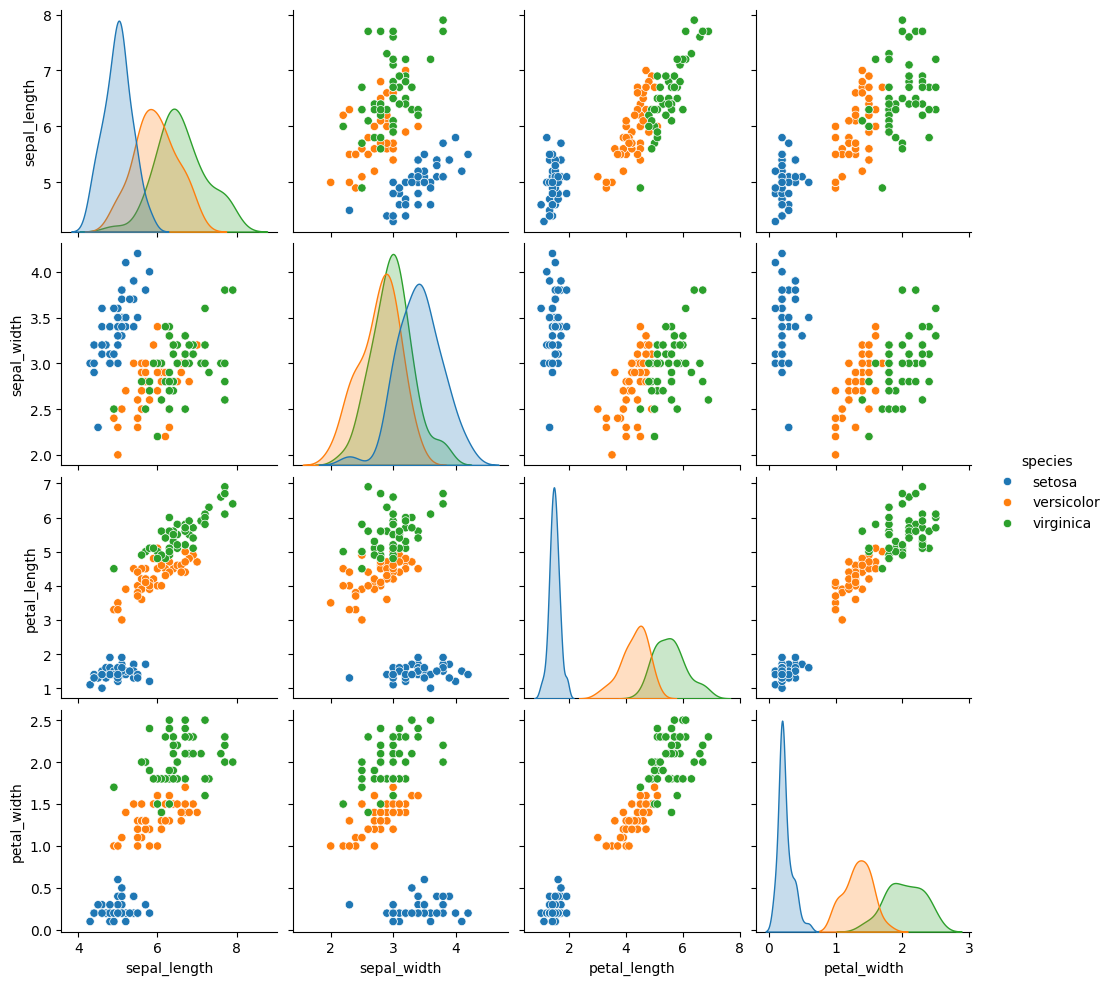

In [12]:
import seaborn as sns

sns.pairplot(df, hue ='species')


The plots on the diagonal with different colors depending on species represent histograms or density estimates of the distribution of each feature for each species separately. They allow for comparisons of feature distributions between different species in a concise manner.

#### 4.2 **[2pt]** Plot the correlation matrix as a heatmap, adding the values on the squares as seen in the lecture's example. Explain what high values of covariance (>0.9 or <-0.9) mean from a statistical perspective, and the implications for the learning process.

Hint: could it be a "common data problem"? Also add the parameter `fmt=` to round to 1 decimal.

<Axes: >

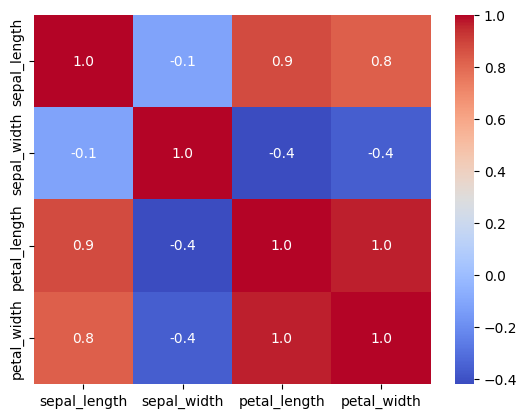

In [13]:
numeric_data = df.select_dtypes(include=['float64'])
corr = numeric_data.corr() #correlation matrix

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f")

High values of covariance ($>0.9$ or $<-0.9$) indicate a strong linear relationship between variables. In statistical terms, this means changes in one variable are highly associated with changes in another. For learning, it can lead to multicollinearity, where features are redundant, making models unstable and less interpretable.

#### 4.3 **[2pt]** Plot a violin plot of the features. Use a custom palette. Briefly explain the advantage of the violin plot over the box plot.

Palettes can be found [[here]](https://seaborn.pydata.org/tutorial/color_palettes.html). You can use `plt.xticks(rotation=45)` (or similar) to rotate the $x$ axis labels if they overlap.

<Axes: >

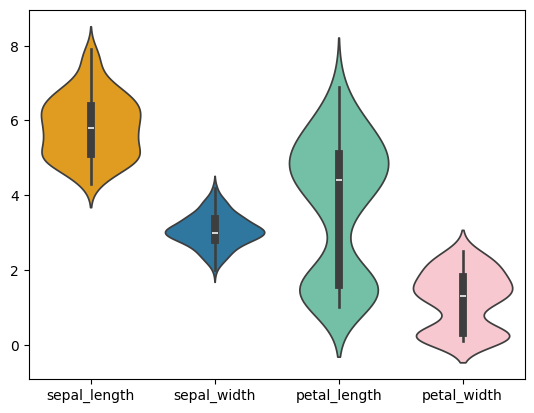

In [14]:
custom_palette = ["#ffa500", "#1c7cb2", "#66cdaa", "#ffc0cb"]
sns.violinplot(data=df, palette = custom_palette)

The advantage of a violin plot over a box plot is that it provides a more informative visualization of the data distribution, it is more pleasing for the human eye. We can see the entire distribution, including the shape and the spread. This allows for a clearer understanding of the data's density and distribution across different values.

# 5. Visualizing the performance

#### 5.1 **[2pt]** Use scikit-learn to train a Linear Regression to predict the petal length ($\hat{y}$) from the petal width ($x$). Generate the Prediction over Observation plot.

Careful, the integration between Pandas and Scikit-learn is relatively [recent](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62). If you find it confusing, stick to numpy arrays, for example:
```python
x = df['petal_width'].to_numpy().reshape((-1, 1))
y = df['petal_length'].to_numpy()
```
Remember scikit-learn needs 2D input, so you need reshaping. To plot the diagonal line a simple line plot with two points will generate a segment, e.g. `sns.lineplot([0,7],[0,7])`.

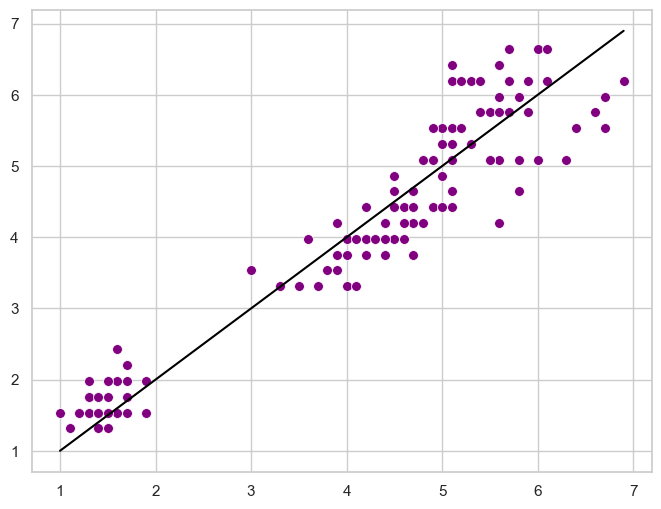

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

x = df['petal_width'].to_numpy().reshape((-1, 1))
y = df['petal_length'].to_numpy()

trained = LinearRegression().fit(x, y)
y_scikit_pred = trained.predict(x)
#print(y_scikit_pred)

def todays_data_plot():
    sns.scatterplot(x=y, y=y_scikit_pred, s=50, color = "purple")
    plt.grid(True)
def todays_model_plot():
    sns.lineplot(x=y, y=y, color="black")  # diagonal line

todays_data_plot()
todays_model_plot()


#### 5.2 **[2pt]** Using the same model and predictions from the last point, generate the Errors over Predictions plot.

Here you want at least one horizontal line for $y=0$: use the segment trick from the previous question. Ideally it looks best with two more lines at $y=+1$ and $y=-1$ for the standard deviation. These can be made thinner or lighter in color to look even better :) I simply used the `alpha` option to make them slightly transparent.

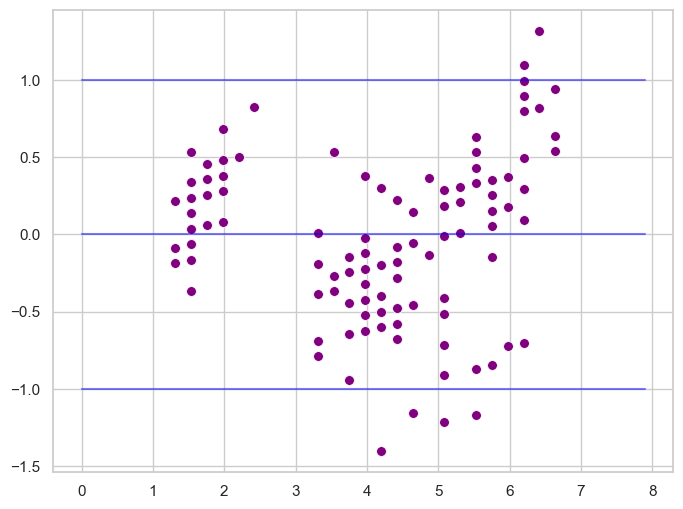

In [16]:
def error_loss(val,pred):
    return((val-pred))

errors = [error_loss(a,b) for a,b in zip(y_scikit_pred,y)]
#print(errors)

def todays_data_plot(errors):
    sns.scatterplot(x=y_scikit_pred, y=errors, s=50, color = "purple")
    plt.grid(True)
def todays_model_plot():
    sns.lineplot(x=[0, y.max()+1], y=[0, 0], color = "blue", alpha = 0.5) #alpha is used to make the lines slightly transparent
    sns.lineplot(x=[0, y.max()+1], y=[1, 1], color = "blue", alpha = 0.5)
    sns.lineplot(x=[0, y.max()+1], y=[-1, -1], color = "blue", alpha = 0.5)

todays_data_plot(errors)
todays_model_plot()

#### 5.3 **[2pt]** For both Prediction over Observation and Errors over Prediction, write a few sentences commenting on the performance of the model learned by the Linear Regression.

A) Prediction over Observation: The close alignment of points along the diagonal line indicates a strong correspondence between the model's predictions and the actual observations, suggesting an overall robust fit. 

B) Errors over Prediction: Although most errors are relatively small, with the majority falling within a range of one (in absolute value), the presence of a few larger errors highlights potential areas where the model may not perform as accurately.

# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

#### BONUS **[ZERO pt]** Follow [this tutorial](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5) to augment your answers to point 5 with 5-fold cross-validation.

In [17]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

model = LinearRegression()
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=42) # we initialize KFold cross-validation with 5 splits

for train_index, test_index in kfold.split(x): # we perform cross-validation
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(x_train, y_train)
    
    score = model.score(x_test, y_test)
    scores.append(score)

print("R-squared Scores for 5-fold cross-validation:", scores)


R-squared Scores for 5-fold cross-validation: [0.9451299794215898, 0.946434683437446, 0.9088194483089552, 0.9188402233514698, 0.8958509898166719]


The model consistently performs well across different data subsets : high R-squared scores, ranging from approximately 0.896 to 0.946. Hence, the results suggest that the relationship between petal width and petal length is robust and generalizable across various scenarios.

#### BONUS **[ZERO pt]** Follow [this tutorial](https://elitedatascience.com/python-seaborn-tutorial) but using our data, and generate all the plots of types that have not been mentioned in the lecture/lab. Comment a few sentences about which I think would be most useful to include in our set of basic plots for the next year.

<Axes: >

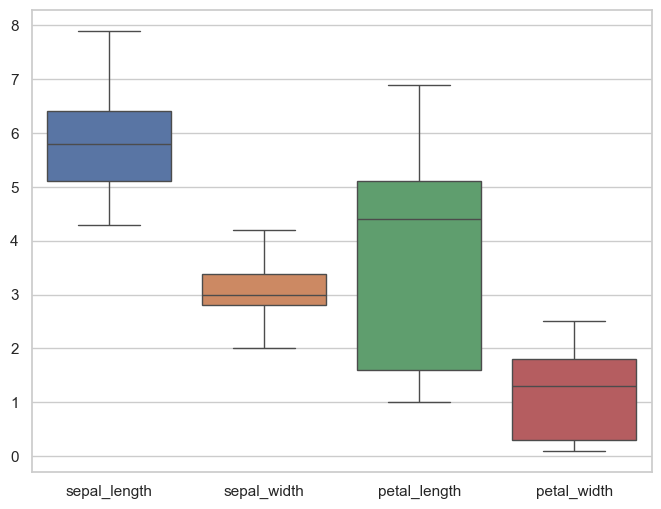

In [18]:
sns.boxplot(data=df) # box plot

<Axes: xlabel='species', ylabel='petal_length'>

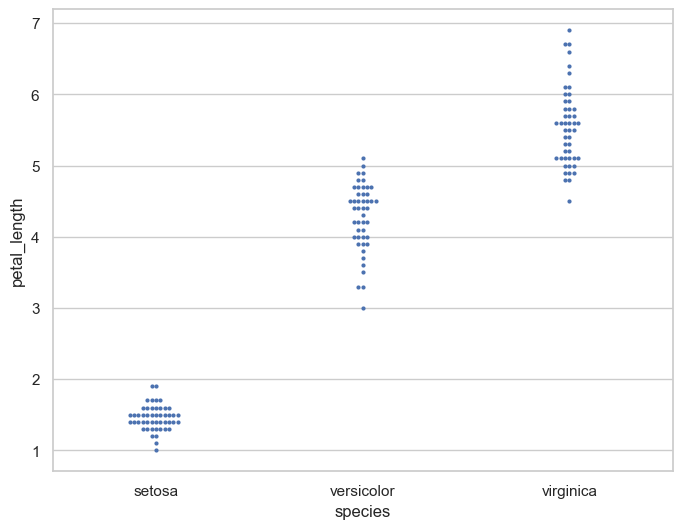

In [19]:
sns.swarmplot(x='species', y='petal_length', data=df, size = 3) #swarm plot

<Axes: xlabel='petal_length', ylabel='Count'>

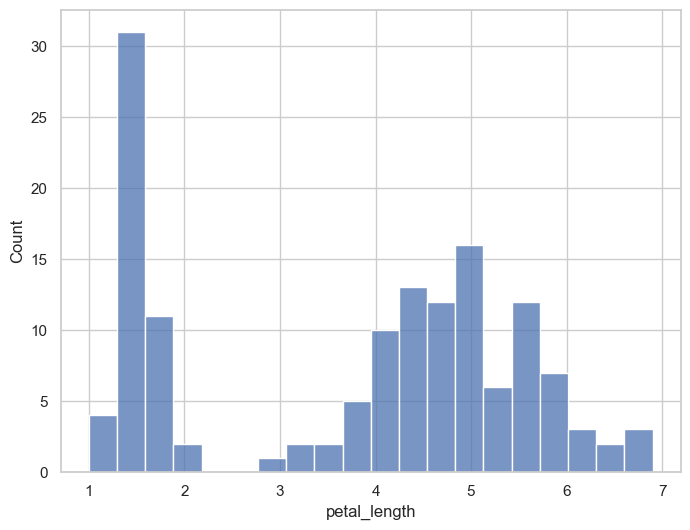

In [20]:
sns.histplot(data=df, x='petal_length', bins=20)

<Axes: xlabel='species', ylabel='petal_length'>

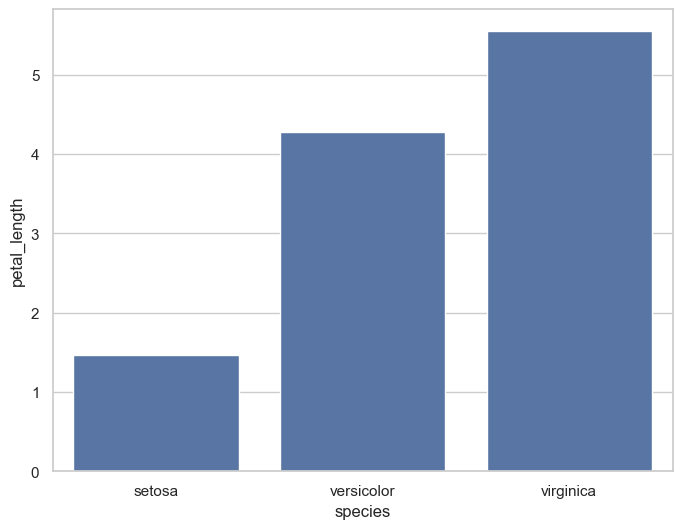

In [21]:
sns.barplot(data=df, x='species', y='petal_length', errorbar=None)

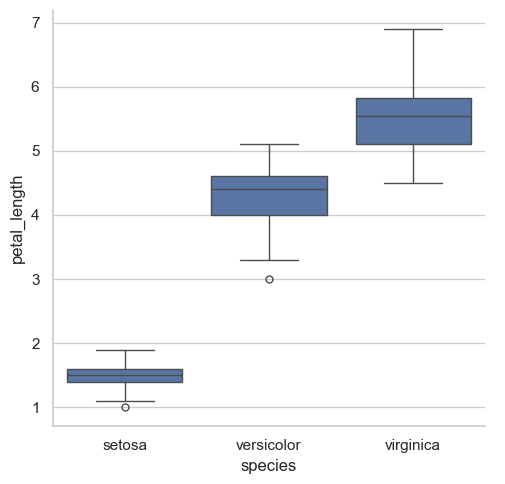

In [22]:
sns.catplot(data=df, x='species', y='petal_length', kind='box')

<Axes: xlabel='petal_length', ylabel='Density'>

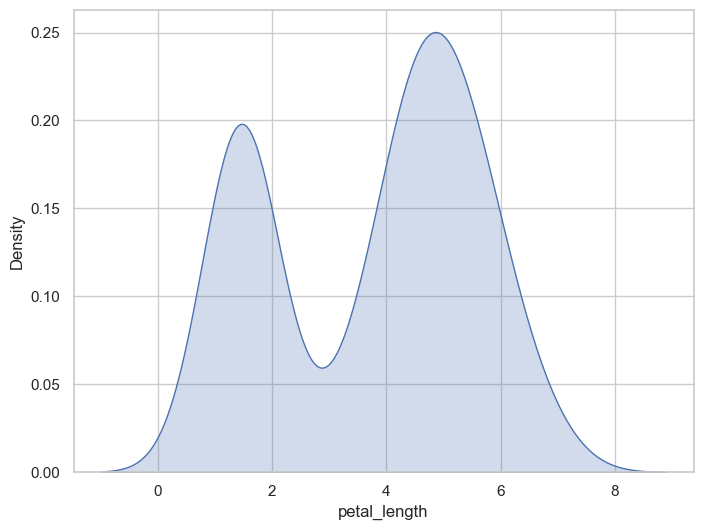

In [23]:
sns.kdeplot(data=df['petal_length'], fill=True)

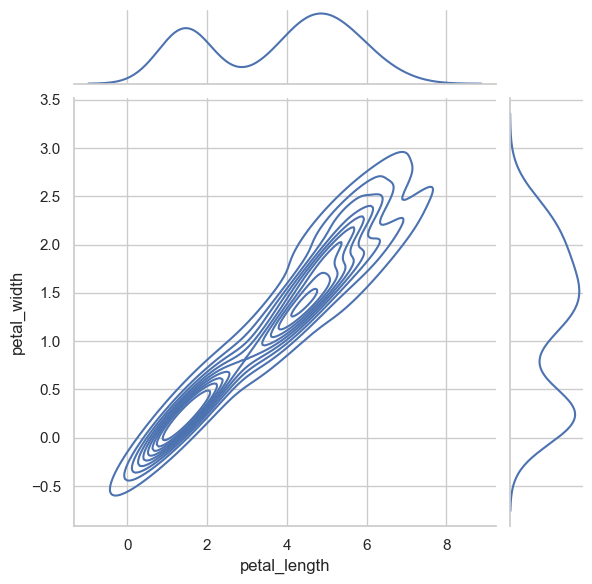

In [24]:
sns.jointplot(data=df, x='petal_length', y='petal_width', kind='kde')

I believe the swarmplot is a nice graph to use because it is really visual and you can imagine the shape of the flowers just by seing the plot !

#### BONUS **[ZERO pt]** Copy your Perceptron implementation from the second lab. Modify it so that at every update it computes the Risk (total Loss over all points) and saves it to a list (we did something similar at the first lab, remember?). Run your implementation on the data, then plot  the Risk over Iterations, using a `sns.lineplot()`.

If you discuss these points on Moodle I will participate :) plus it will give you an opportunity to find other people in the class that interested with going beyond the points: I strongly encourage these to team together (remember you can change teammate at each assignment).

### Final considerations

- This lecture+lab actually gives you most of what you need for the high-pay job of Data Analyst, so I guess there is one direct market application from this course after all :)
- You will need to be strong in all the topics seen so far to carry on with the course.
- Fixing and polishing your past assignments will make passing the exam so much easier. Now is the perfect chance to prepare the first 3.